In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
pip install 'tfrecord[torch]'


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
from pathlib import Path
from zipfile import ZipFile
import urllib.request
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms.functional as Ft
from torchvision.utils import draw_bounding_boxes
from tfrecord.torch.dataset import MultiTFRecordDataset
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [8]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=24, out_channels=1, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Upsample(64),
            nn.Flatten(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.Unflatten(1, (64, 64)),
        )

    def forward(self, x):
        return self.cnn(x).unsqueeze(1)


In [9]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class ConvoAE(torch.nn.Module):
    def __init__(self):
        super(ConvoAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(12, 24, 3, 1, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(24, 24, 3, 1, 0),  # 32 x 32 -> 30 x 30
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Conv2d(24, 32, 3, 2, 0),  # 30 x 30 -> 14 x 14
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, 2, 0),  # 14 x 14 -> 6 x 6
            nn.Flatten(),
            nn.Linear(1152, 2),  # 1152 = 32 * 6  * 6
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 1152),
            Reshape(-1, 32, 6, 6),
            nn.ConvTranspose2d(32, 32, 3, 1, 0),  # 6 x 6 -> 8 x 8
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 16, 3, 2, 1),  # 8 x 8 -> 15 x 15
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(16, 16, 3, 2, 0),  # 15 x 15 -> 31 x 31
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(16, 8, 3, 1, 0),  # 31 x 31 -> 33 x 33
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(8, 1, 2, 2, 1),  # 33 x 33 -> 64 x 64
            nn.Flatten(),
            nn.Linear(in_features=4096, out_features=4096 * 2),
            nn.Unflatten(1, (2, 4096)),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
def reweight(cls_num_list, beta=0.9999):
    per_cls_weights = torch.Tensor(
        list(map(lambda n: (1 - beta) / (1 - beta**n), cls_num_list))
    )
    per_cls_weights *= len(cls_num_list) / per_cls_weights.sum()
    return per_cls_weights


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.0):
        super().__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        return F.cross_entropy(
            (1 - F.softmax(input, dim=1)) ** self.gamma * F.log_softmax(input, dim=1),
            target,
            weight=self.weight,
        )


In [11]:
# https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d

def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [46]:
# parameters
BATCH_SIZE=512
FEATURES = [
    "elevation",
    "th",
    "vs",
    "tmmn",
    "tmmx",
    "sph",
    "pr",
    "pdsi",
    "NDVI",
    "population",
    "erc",
    "PrevFireMask",
]
LABELS = ["FireMask"]

EPOCHS = 10
LEARNING_RATE = 1e-2

ARR_SIZE = 4096
LENGTH, WIDTH = 64, 64

# visualize features and labels

rows = 5
cols = 14
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

TITLES = [
    'Elevation',
    'Wind Direction',
    'Wind Velocity',
    'Min Temperature',
    'Max Temperature',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population Density',
    'Energy Release Component',
    'Previous Fire Mask',
    'True Fire Mask',
    'Predicted Fire Mask',
]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

In [13]:
# set up data directory
data_dir = os.path.join(os.path.abspath("."), "data")
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [14]:
# download data zip
data_zip = os.path.join(data_dir, "archive.zip")
if not os.path.exists(data_zip):
    url = "https://www.kaggle.com/api/v1/datasets/download/fantineh/next-day-wildfire-spread"
    urllib.request.urlretrieve(url, data_zip)

In [15]:
# extract files from zip
files = defaultdict(list)
file_types = ["eval", "train", "test"]
with ZipFile(data_zip, "r") as z:
    for file in z.namelist():
        for file_type in file_types:
            if file_type in file:
                files[file_type].append(Path(file).stem)
        if not os.path.exists(os.path.join(data_dir, file)):
            z.extract(file, data_dir)

In [16]:
# get all records into a data loader
from torch.utils.data import default_collate
def collate_fn(batch):
    batch = [b for b in batch if (-1 not in b['PrevFireMask']) and (-1  not in b['FireMask'])]
    if batch:
        return default_collate(batch)

def get_loader_from_file_type(files: list,  record_path: str, file_types: list):
    f = [file for file_type in file_types for file in files[file_type]]
    dataset = MultiTFRecordDataset(
        tfrecord_path,
        None,
        splits={file: 1.0 for file in f},
        infinite=False
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    return loader

tfrecord_path = os.path.join(data_dir, "{}.tfrecord")
train_loader = get_loader_from_file_type(files, tfrecord_path, ["train"])
test_loader = get_loader_from_file_type(files, tfrecord_path, ["test", "eval"])

In [17]:
def plot_losses(train_losses, test_losses):
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(test_losses)+1), test_losses, label="Test Loss")
    plt.xticks(range(1, len(train_losses)+1))
    plt.legend()
    plt.show()

In [18]:
data = next(iter(train_loader))
print(data['FireMask'].shape)

data = next(iter(test_loader))
print(data['FireMask'].shape)

torch.Size([85, 4096])
torch.Size([71, 4096])


In [19]:
def get_dataset_items(data, item_list, length=LENGTH, width=WIDTH):
    items = torch.cat([data[key][:, None, :] for key in item_list], dim=1)
    items = items.reshape(items.shape[0], items.shape[1], length, width)
    return items.to(device)

In [20]:
# gather batch of features
features = get_dataset_items(data, FEATURES)
labels = get_dataset_items(data, LABELS)
print(features.shape)
print(labels.shape)

torch.Size([71, 12, 64, 64])
torch.Size([71, 1, 64, 64])


# Encoder-Decoder with Focal Loss

In [108]:
# get class counts
class_counts = torch.zeros(2).to(device)
for data in iter(train_loader):
    label_batch = get_dataset_items(data, LABELS)
    n_classes = label_batch.unique(return_counts=True)[1].to(device)
    class_counts += n_classes

In [109]:
# from models.focal_loss import reweight
per_class_weights = reweight(class_counts, beta=.9999999).to(device)
print(per_class_weights)

tensor([0.0948, 1.9052])


In [110]:
def train(model, loss_fn, loader, optimizer):
    model.train()
    total_loss = 0
    for i, data in enumerate(loader):
        features = get_dataset_items(data, FEATURES)
        labels = get_dataset_items(data, LABELS)

        pred = model(features)

        _pred = torch.flatten(torch.flatten(pred, 2).transpose(0, 1), 1).transpose(0, 1)
        _labels =torch.flatten(labels).long()

        loss = loss_fn(_pred, _labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if i % 100 == 0:
        loss_val, current = loss.item(), i * BATCH_SIZE + len(features)
        total_loss += loss_val
    print(f"Train loss: {total_loss:>7f}")
    return loss, features, labels, total_loss

In [111]:
def test(model, loss_fn, loader):
    model.eval()
    total_loss, correct = 0, 0
    all_pred = []
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            features = get_dataset_items(data, FEATURES)
            labels = get_dataset_items(data, LABELS)
            # Compute prediction and loss
            pred = model(features)
            _pred = torch.flatten(torch.flatten(pred, 2).transpose(0, 1), 1).transpose(0, 1)
            _labels =torch.flatten(labels).long()

            loss = loss_fn(_pred, _labels)
            total_loss += loss.item()
            all_pred.append(pred)
            all_features.append(features)
            all_labels.append(labels)
    print(f"Test loss: {total_loss:>7f}")
    return all_pred, all_features, all_labels, total_loss

Epoch 1
Train loss: 80.278201
Test loss: 18.422003
Epoch 2
Train loss: 72.138152
Test loss: 15.044119
Epoch 3
Train loss: 49.508512
Test loss: 12.627543
Epoch 4
Train loss: 43.389327
Test loss: 11.331819
Epoch 5
Train loss: 42.831786
Test loss: 11.535594
Epoch 6
Train loss: 42.694987
Test loss: 11.415885
Epoch 7
Train loss: 42.965968
Test loss: 12.385021
Epoch 8
Train loss: 42.561839
Test loss: 10.952035
Epoch 9
Train loss: 42.320141
Test loss: 10.816787
Epoch 10
Train loss: 41.827816
Test loss: 10.999273


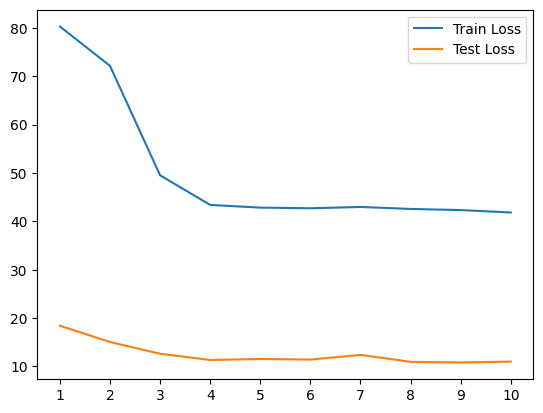

In [112]:
# from models.encoder_decoder import ConvoAE
# from models.focal_loss import FocalLoss
model = ConvoAE()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = FocalLoss(weight=per_class_weights)

train_losses=[]
test_losses=[]

for t in range(EPOCHS):
    print(f'Epoch {t+1}\n')
    loss, features, labels, train_loss = train(model, loss_fn, train_loader, optimizer)
    test_pred, test_features, test_labels, test_loss = test(model, loss_fn, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
plot_losses(train_losses, test_losses)

In [113]:
results = []
for pred, labels in zip(test_pred, test_labels):
    _pred = torch.flatten(torch.flatten(pred, 2).transpose(0, 1), 1).transpose(0, 1).argmax(1)
    _labels = torch.flatten(labels).long() 
    results.append(confusion(_pred, _labels))

total = len(results)
tps, fps, tns, fns = 0, 0, 0, 0
for result in results:
    (tp, fp, tn, fn) = result
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
print(f"False Positive Rate: {fps/(fps+tns):>2f}")
print(f"False Negative Rate: {fns/(fns+tps):>2f}")

False Positive Rate: 0.026316
False Negative Rate: 0.651323


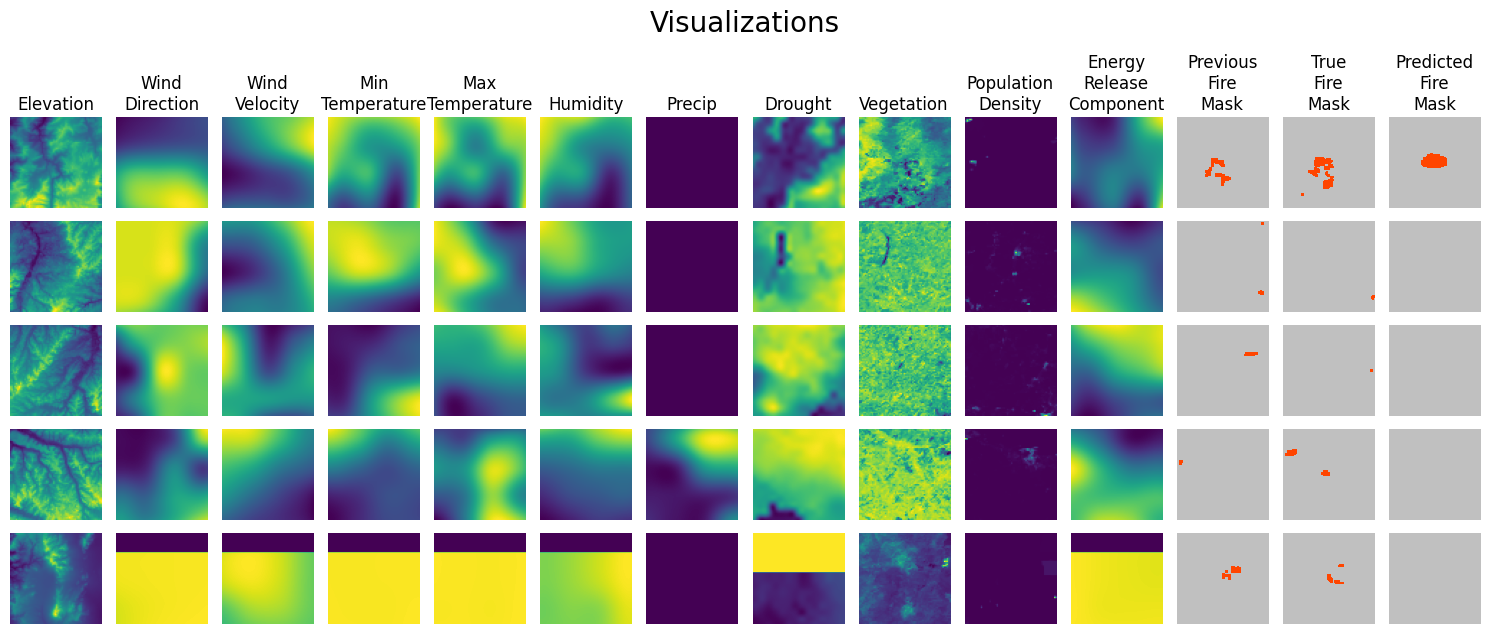

In [114]:
fig = plt.figure(figsize=(15,6.5))
fig.suptitle("Visualizations", fontsize=20)
# samples
features = test_features[0]
labels = test_labels[0]
pred = test_pred[0]
for i in range(rows):
    # features and labels

    pred = pred.argmax(1, keepdim=True).reshape(pred.shape[0], 1, LENGTH, WIDTH)

    plots = torch.cat((features[i], labels[i], pred[i]), dim=0)
    for j, plot in enumerate(plots):
        try:
            plot = plot.cpu()
        except:
            plot = plot.detach().numpy()
        plt.subplot(rows, cols, i*cols+j+1)
        if i==0:
            title = TITLES[j].replace(' ', '\n')
            plt.title(title)
        if j >= cols-3:
            plt.imshow(plot, cmap=CMAP, norm=NORM)
        else:
            plt.imshow(plot, cmap='viridis')
        plt.axis('off')
plt.tight_layout()

# RCNN Object Detection

In [49]:
def make_rcnn_target(labels: list[torch.Tensor], n_boxes=2, l=64, w=64, label_function=torch.max):
    """
    length and width should be divisible evenly by n
    i.e., 64x64 iMmage can have 2, 4, 8, etc. evenly spaced boxes

    Create list of dict, each containing box bounds and corresponding labels for the boxes
    Number of boxes is in one side of the resulting square, i.e., boxes=2 makes 4 boxes, boxes=4 makes 16 boxes
    Label function determines how the label is computed, usually either the max or mode of the box's area
    """
    assert l%n_boxes==0
    assert w%n_boxes==0

    x_step = int(l/n_boxes)
    y_step = int(w/n_boxes)
    targets = []

    for label in labels:
        boxes = torch.zeros((n_boxes**2, 4)).to(device)
        target_labels = torch.zeros((n_boxes**2)).type(torch.int64).to(device)
        for x in range(n_boxes):
            for y in range(n_boxes):
                boxes[x*n_boxes+y]=torch.Tensor([[x*x_step, y*y_step, (x+1)*x_step-1, (y+1)*y_step-1]]).to(device)
                target_labels[x*n_boxes+y]=torch.Tensor(
                    [label_function(label[0, x*x_step:(x+1)*x_step, y*y_step:(y+1)*y_step])]
                 ).to(device)

        targets.append({"boxes": boxes, "labels": target_labels})
    return targets

In [50]:
def train(model, rcnn, loader, optimizer, n_boxes=2):
    model.train()
    rcnn.train()
    total_loss = 0
    for i, data in enumerate(loader):
        features = get_dataset_items(data, FEATURES)[0:3]
        labels = get_dataset_items(data, LABELS)[0:3]
        weights = model(features).to(device)
        target = make_rcnn_target(labels, n_boxes=n_boxes)
        loss = rcnn(weights, target)["loss_classifier"]

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if i % 100 == 0:
        loss_val, current = loss.item(), i * BATCH_SIZE + len(features)
        total_loss += loss_val
    print(f"Train loss: {total_loss:>7f}")
    return loss, features, labels, weights, total_loss

In [51]:
def test(model, rcnn, loader):
    model.eval()
    rcnn.eval()
    total_loss, correct = 0, 0
    # output = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            features = get_dataset_items(data, FEATURES)[0:3]
            labels = get_dataset_items(data, LABELS)[0:3]
            # Compute prediction and loss
            weights = model(features).to(device)
            output = rcnn(weights)
    return output, features, labels

In [52]:
def calculate_test_loss(model, rcnn, loader, n_boxes=2):
    """Hacky workaround to get test losses for RCNN"""
    total_loss = 0
    model.eval()
    rcnn.train()
    with torch.no_grad():
        for i, data in enumerate(loader):
            features = get_dataset_items(data, FEATURES)[0:3]
            labels = get_dataset_items(data, LABELS)[0:3]
            target = make_rcnn_target(labels, n_boxes=n_boxes)

            # Compute prediction and loss
            weights = model(features)
            loss = rcnn(weights, target)
            total_loss+=loss['loss_classifier'].item()
    print(f"Test loss: {total_loss:>7f}")
    return loss, total_loss

Epoch 1
Train loss: 133.462027
Test loss: 19.175084
Epoch 2
Train loss: 79.244846
Test loss: 18.495475
Epoch 3
Train loss: 76.980958
Test loss: 18.049668
Epoch 4
Train loss: 75.400562
Test loss: 17.752427
Epoch 5
Train loss: 74.345319
Test loss: 17.551466
Epoch 6
Train loss: 73.734986
Test loss: 17.442188
Epoch 7
Train loss: 73.412239
Test loss: 17.407772
Epoch 8
Train loss: 73.142922
Test loss: 17.362540
Epoch 9
Train loss: 72.888019
Test loss: 17.273726
Epoch 10
Train loss: 72.657232
Test loss: 17.182860


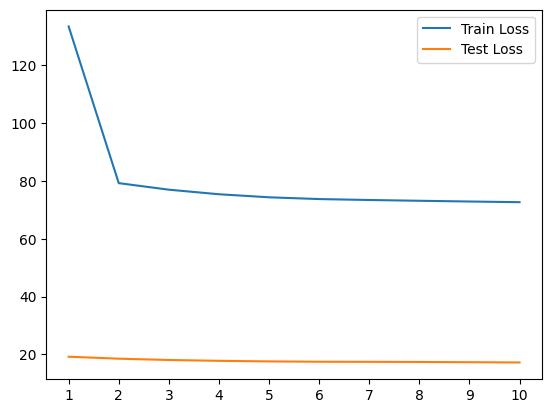

In [53]:
# from models.cnn import CNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = CNN()
rcnn = fasterrcnn_resnet50_fpn(num_classes=num_classes, progress=True)

model.to(device)
rcnn.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, test_losses = [], []

for t in range(EPOCHS):
    print(f'Epoch {t+1}\n')
    _, _, _, weights, train_loss = train(model, rcnn, train_loader, optimizer, n_boxes=2)
    pred, features, labels = test(model, rcnn, test_loader)
    _, test_loss = calculate_test_loss(model, rcnn, test_loader, n_boxes=2)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
plot_losses(train_losses, test_losses)


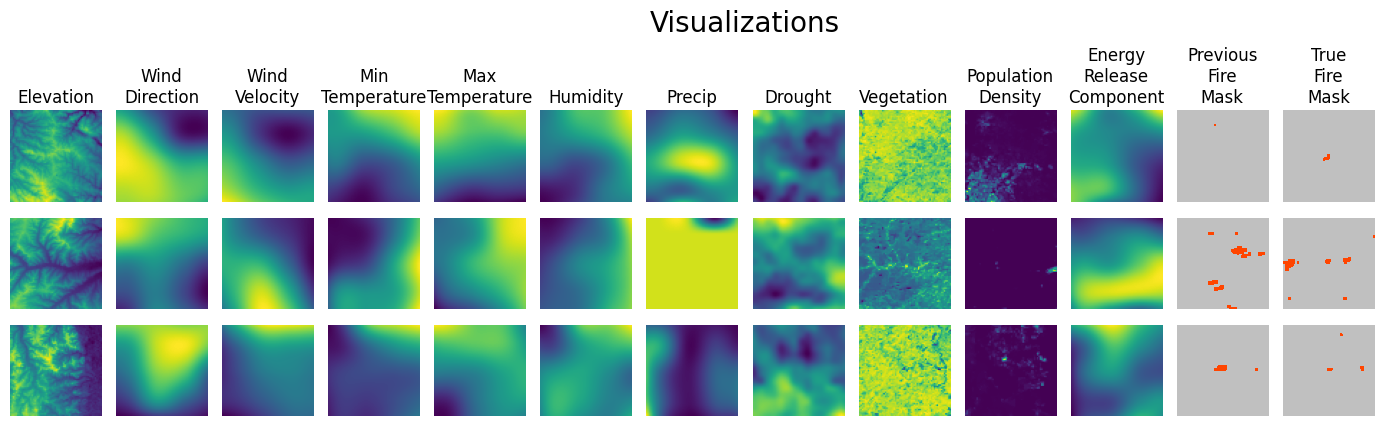

In [58]:
fig = plt.figure(figsize=(15,6.5))
fig.suptitle("Visualizations", fontsize=20)
# samples
for i in range(3):
    # features and labels
    plots = torch.cat((features[i], labels[i]), dim=0)
    for j, plot in enumerate(plots):
        plot = plot.detach().numpy()
        plt.subplot(rows, cols, i*cols+j+1)
        if i==0:
            title = TITLES[j].replace(' ', '\n')
            plt.title(title)
        if j >= cols-3:
            plt.imshow(plot, cmap=CMAP, norm=NORM)
        else:
            plt.imshow(plot, cmap='viridis')
        plt.axis('off')
plt.tight_layout()

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


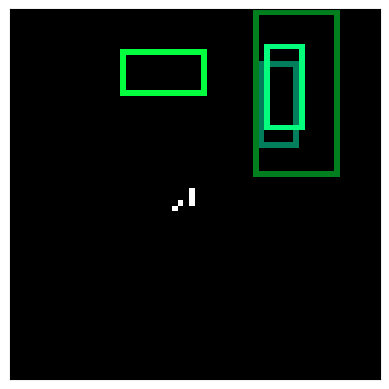

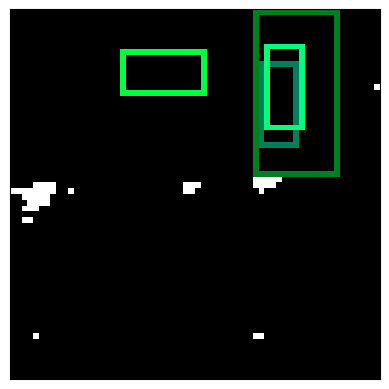

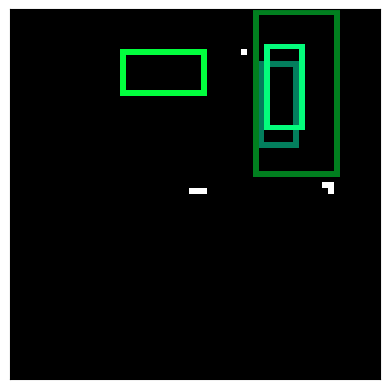

In [60]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Ft.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

BOXES = 5
for i in range(3):
    boxed = draw_bounding_boxes(labels[i], pred[i]['boxes'][0:BOXES])
    show(boxed)

In [ ]:
results = []
for _pred, _labels in zip(pred, labels):
    # _pred = torch.flatten(torch.flatten(pred, 2).transpose(0, 1), 1).transpose(0, 1).argmax(1)
    # _labels = torch.flatten(labels).long() 
    results.append(confusion(_pred, _labels))

total = len(results)
tps, fps, tns, fns = 0, 0, 0, 0
for result in results:
    (tp, fp, tn, fn) = result
    tps += tp
    fps += fp
    tns += tn
    fns += fn
    
print(f"False Positive Rate: {fps/(fps+tns):>2f}")
print(f"False Negative Rate: {fns/(fns+tps):>2f}")

10